<a href="https://colab.research.google.com/github/martinez-ie/player_churn_prediction/blob/main/churn_games_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Etapas do Projeto e Código

In [16]:
# 1. Importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [17]:
# 2. Simular base de dados

num_jogadores = 1000
user_ids = np.arange(1, num_jogadores + 1)
play_time = np.random.exponential(scale=40, size=num_jogadores).astype(int)
sessions = np.random.poisson(lam=20, size=num_jogadores)
days_since_last_login = np.random.randint(0, 30, size=num_jogadores)
levels = np.random.randint(1, 51, size=num_jogadores)
in_game_purchases = np.random.poisson(lam=1.5, size=num_jogadores)

# Variável alvo: churn
churned = (
    (play_time < 20) &
    (days_since_last_login > 10) &
    (in_game_purchases == 0)
).astype(int)

# Novas variáveis
avg_session_time = np.divide(play_time, sessions, out=np.zeros_like(play_time, dtype=float), where=sessions != 0)
total_matches = np.random.randint(5, 100, size=num_jogadores)
wins = np.random.randint(0, total_matches + 1)
win_rate = np.round(np.divide(wins, total_matches, out=np.zeros_like(wins, dtype=float), where=total_matches != 0), 2)

# Criar DataFrame final
df = pd.DataFrame({
    'user_id': user_ids,
    'play_time': play_time,
    'sessions': sessions,
    'avg_session_time': avg_session_time,
    'days_since_last_login': days_since_last_login,
    'level': levels,
    'in_game_purchases': in_game_purchases,
    'total_matches': total_matches,
    'wins': wins,
    'win_rate': win_rate,
    'churned': churned
})

📊 Dimensões da base: (1000, 11)

📌 Tipos de dados:
user_id                    int64
play_time                  int64
sessions                   int64
avg_session_time         float64
days_since_last_login      int64
level                      int64
in_game_purchases          int64
total_matches              int64
wins                       int64
win_rate                 float64
churned                    int64
dtype: object

🔍 Valores nulos por coluna:
user_id                  0
play_time                0
sessions                 0
avg_session_time         0
days_since_last_login    0
level                    0
in_game_purchases        0
total_matches            0
wins                     0
win_rate                 0
churned                  0
dtype: int64

📈 Estatísticas descritivas:
           user_id   play_time     sessions  avg_session_time  \
count  1000.000000  1000.00000  1000.000000       1000.000000   
mean    500.500000    40.78100    19.925000          2.172993   
std     2

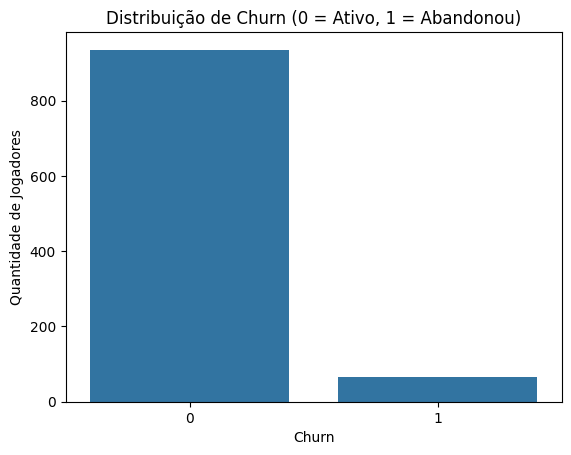

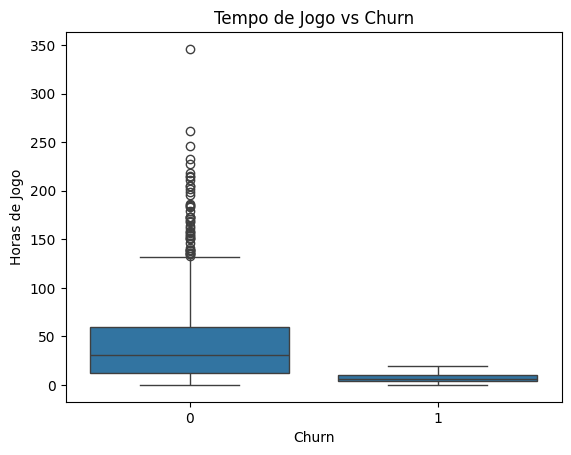

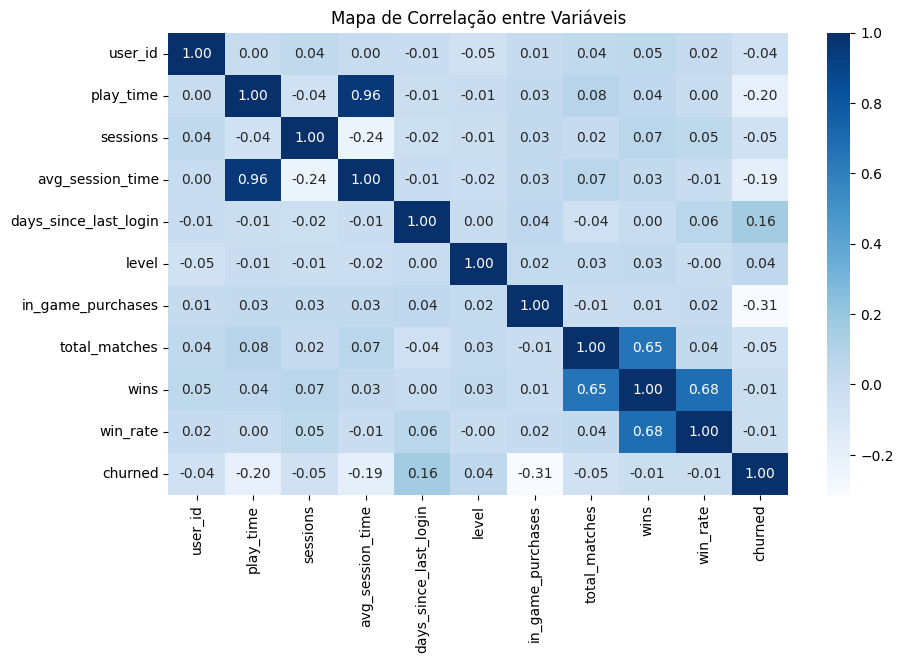

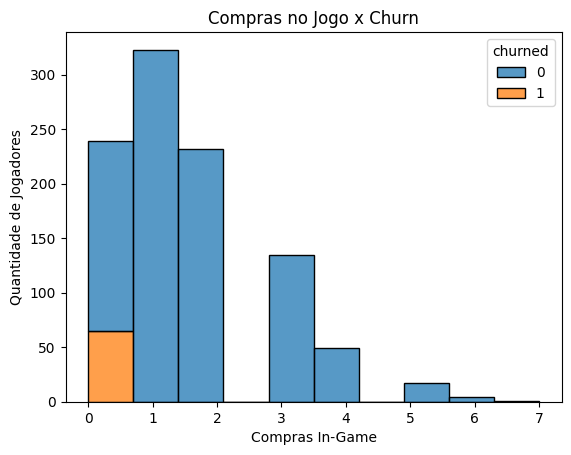

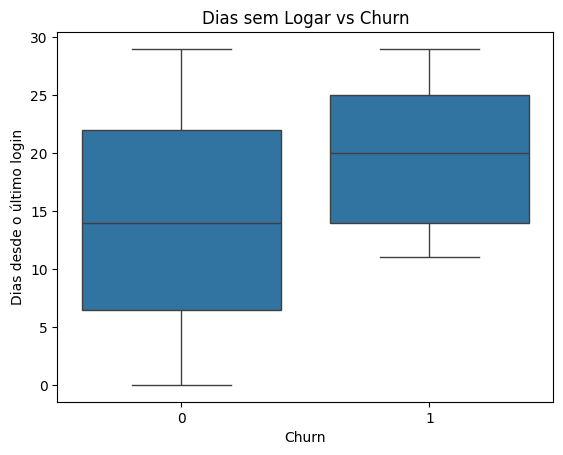

In [23]:
# 1. Visão geral da base
print("📊 Dimensões da base:", df.shape)
print("\n📌 Tipos de dados:")
print(df.dtypes)

# 2. Verificando valores nulos
print("\n🔍 Valores nulos por coluna:")
print(df.isnull().sum())

# 3. Estatísticas descritivas
print("\n📈 Estatísticas descritivas:")
print(df.describe())

# 4. Proporção de churn
print("\n🎮 Proporção de jogadores que abandonaram o jogo:")
print(df['churned'].value_counts(normalize=True))

# 5. Gráfico de distribuição de churn
sns.countplot(data=df, x='churned')
plt.title('Distribuição de Churn (0 = Ativo, 1 = Abandonou)')
plt.xlabel('Churn')
plt.ylabel('Quantidade de Jogadores')
plt.show()

# 6. Boxplot do tempo de jogo por churn
sns.boxplot(data=df, x='churned', y='play_time')
plt.title('Tempo de Jogo vs Churn')
plt.xlabel('Churn')
plt.ylabel('Horas de Jogo')
plt.show()

# 7. Correlação entre variáveis numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

# 8. Histograma de compras dentro do jogo
sns.histplot(data=df, x='in_game_purchases', hue='churned', multiple='stack', bins=10)
plt.title('Compras no Jogo x Churn')
plt.xlabel('Compras In-Game')
plt.ylabel('Quantidade de Jogadores')
plt.show()

# 9. Dias desde o último login por churn
sns.boxplot(data=df, x='churned', y='days_since_last_login')
plt.title('Dias sem Logar vs Churn')
plt.xlabel('Churn')
plt.ylabel('Dias desde o último login')
plt.show()


In [19]:
# 3. Preparar dados

X = df.drop(columns=['user_id', 'churned'])
y = df['churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# 4. Treinar modelos

# Regressão Logística
modelo_log = LogisticRegression(random_state=42)
modelo_log.fit(X_train_scaled, y_train)
y_pred_log = modelo_log.predict(X_test_scaled)

# Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

# XGBoost
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelo_xgb.fit(X_train, y_train)
y_pred_xgb = modelo_xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:45:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
# 5. Avaliação dos modelos
print("📊 Regressão Logística:")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

print("\n🌲 Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

print("\n⚡ XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


📊 Regressão Logística:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       187
           1       1.00      0.77      0.87        13

    accuracy                           0.98       200
   macro avg       0.99      0.88      0.93       200
weighted avg       0.99      0.98      0.98       200

[[187   0]
 [  3  10]]

🌲 Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       187
           1       1.00      1.00      1.00        13

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[187   0]
 [  0  13]]

⚡ XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       187
           1       1.00      1.00      1.00        13

    accuracy                           1.00       200
   macro avg       1.00      

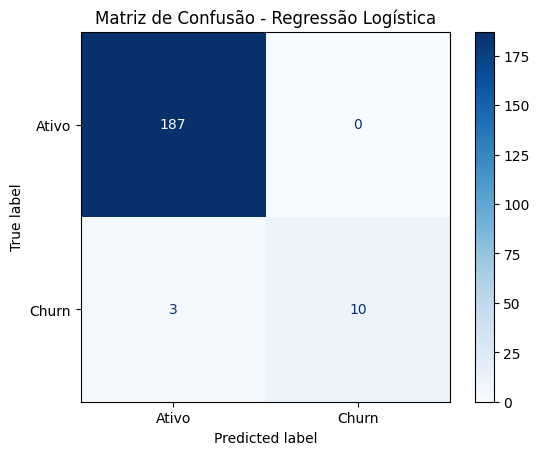

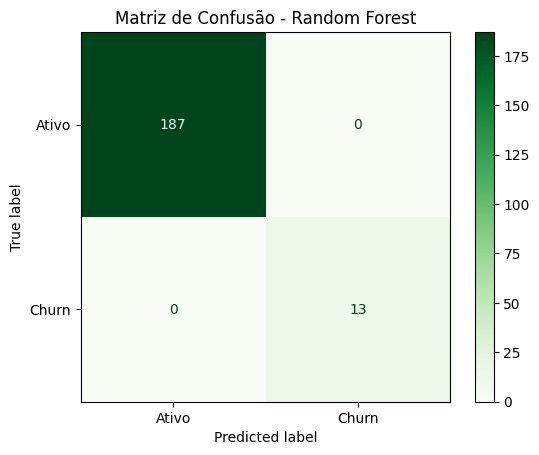

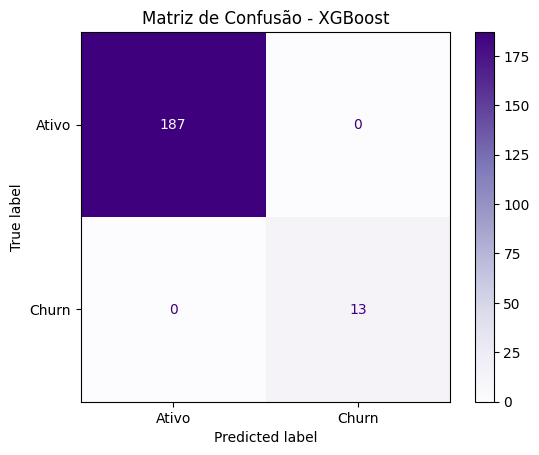

In [22]:
# 6. Visualizações

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, display_labels=["Ativo", "Churn"], cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=["Ativo", "Churn"], cmap='Greens')
plt.title("Matriz de Confusão - Random Forest")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=["Ativo", "Churn"], cmap='Purples')
plt.title("Matriz de Confusão - XGBoost")
plt.show()